# ISEN 427 Final Report 
### Fletcher Newman | April 7th, 2025

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the data in
ump1_orig = pd.read_csv('https://raw.githubusercontent.com/lekhapriya/ISEN_427-627_Project_2025/refs/heads/main/Umpire_1.csv')

In [4]:
def clean_df(orig_df):
    """
    Pitch types:
        ['SI' 'AB' 'SL' 'FC' 'CH' 'CU' 'FF' 'FS' 'EP' 'KC' 'FO' 'KN' 'SC' 'ST'
         'SV' 'CS' 'FA']
    Handedness: R=1, L=0
    Description: 'ball': 0, 'called_strike': 1
    Error in decision: 'correct': 0, 'incorrect': 1
    """
    df = orig_df.copy()
    # Drop nulls 
    df = df.dropna()
    
    # Map pitch types to binary columns
    unique_pt = df['pitch_type'].unique()
    fastballs = ['FF', 'FA', 'FT', 'SI', 'FC'] # 4 seam, 4 seam again, two seam, sinker, cutter
    changeups = ['CH', 'EP', 'FO', 'FS'] # Change, ephus, fork, split
    off_speed = ['SL', 'CU', 'ST', 'SV', 'CS'] # Slider, curve, sweeper, slurve, slow curve
    rare = ['KC', 'KN', 'SC'] # Knucle curve, knuckle ball, screwball
    # AB and AS are 'automatic ball/strike' so they are not included. This happens when something like a pitch clock violation occurs
    # Against the pitcher or the hitter

    # Create new binary columns
    df['fastball'] = df['pitch_type'].isin(fastballs).astype(int)
    df['changeup'] = df['pitch_type'].isin(changeups).astype(int)
    df['off_speed'] = df['pitch_type'].isin(off_speed).astype(int)
    df['rare'] = df['pitch_type'].isin(rare).astype(int)

    # Drop ptich_type column since it is not categorical
    df = df.drop(columns='pitch_type')
    
    # Same with error
    df['error_in_decision'] = df['error_in_decision'].map({'correct': 0, 'incorrect': 1})

    # Fix handedness
    df['stand'] = df['stand'].map({'R': 1, 'L': 0})
    df['p_throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    
    df['description'] = df['description'].map({'ball': 0, 'called_strike': 1})


    # Max min scale the data to make coefficienst more interpretable
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    return df


ump1 = clean_df(ump1_orig)

In [5]:
ump1

,balls,strikes,release_speed,release_pos_x,release_pos_z,description,zone,stand,p_throws,game_year,...,release_pos_y,at_bat_number,pitch_number,home_score,away_score,all_star_player,fastball,changeup,off_speed,rare
0,0.000000,0.0,0.748276,0.323204,0.879141,0.0,0.769231,1.0,1.0,0.0,...,0.473684,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.333333,0.0,0.756897,0.334254,0.891674,0.0,0.769231,1.0,1.0,0.0,...,0.473684,0.000000,0.066667,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.000000,0.0,0.732759,0.330571,0.889884,0.0,0.769231,1.0,1.0,0.0,...,0.473684,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.458621,0.348987,0.898836,1.0,0.769231,1.0,1.0,0.0,...,0.473684,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.000000,1.0,0.568966,0.357274,0.902417,0.0,0.769231,1.0,1.0,0.0,...,0.473684,0.010417,0.133333,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57693,0.333333,0.5,0.862069,0.395028,0.781558,1.0,0.615385,1.0,1.0,1.0,...,0.526316,0.937500,0.133333,1.0,0.5,0.0,1.0,0.0,0.0,0.0
57694,0.000000,0.0,0.715517,0.389503,0.778872,1.0,0.538462,0.0,1.0,1.0,...,0.514874,0.947917,0.000000,1.0,0.5,0.0,0.0,1.0,0.0,0.0
57695,0.000000,0.0,0.846552,0.379374,0.784244,0.0,0.923077,1.0,1.0,1.0,...,0.558352,0.958333,0.000000,1.0,0.5,0.0,1.0,0.0,0.0,0.0
57696,0.000000,0.0,0.868966,0.400552,0.788720,0.0,1.000000,1.0,1.0,1.0,...,0.544622,0.968750,0.000000,1.0,0.5,0.0,1.0,0.0,0.0,0.0


## I want to check the effects of:
- Count
    - Balls, strikes, pitch_number, at_bat_number
- Important situaion
    - delta_home_win_exp, delta_run_exp, home_score, away_score, on_3b/2/1
- Type of pitch (including velo and characteristics)
    - pitch_type (binary for each type), description
- Pitch charactaristics 
    - plate_z, plate_x, release_speed, release_pos_x, release_pos_z, description, pfx_x, pfx_z, vx0, vy0, vz0, ax, ay, az, release_pos_y, pitch_location
- Dimentions of pitcher and hitter
    - all_star_player, sz_bot, sz_top, stand, p_throws, 

### Random Sample of data (for now at least)

In [6]:
X = ump1.sample(n=200, random_state=42) # Only take a small amount so that the modeling doesn't take 5-ever
y_true = np.array(X['error_in_decision'])

### Create model of count situation
**balls, strikes, pitch number, at-bat number**

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [balls, strikes, pitch_number, at_bat_number, intercept]


/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
Sampling: [count_y_obs]


/opt/anaconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

array([<Axes: title={'center': 'balls'}>,
       <Axes: title={'center': 'strikes'}>,
       <Axes: title={'center': 'pitch_number'}>,
       <Axes: title={'center': 'at_bat_number'}>], dtype=object)

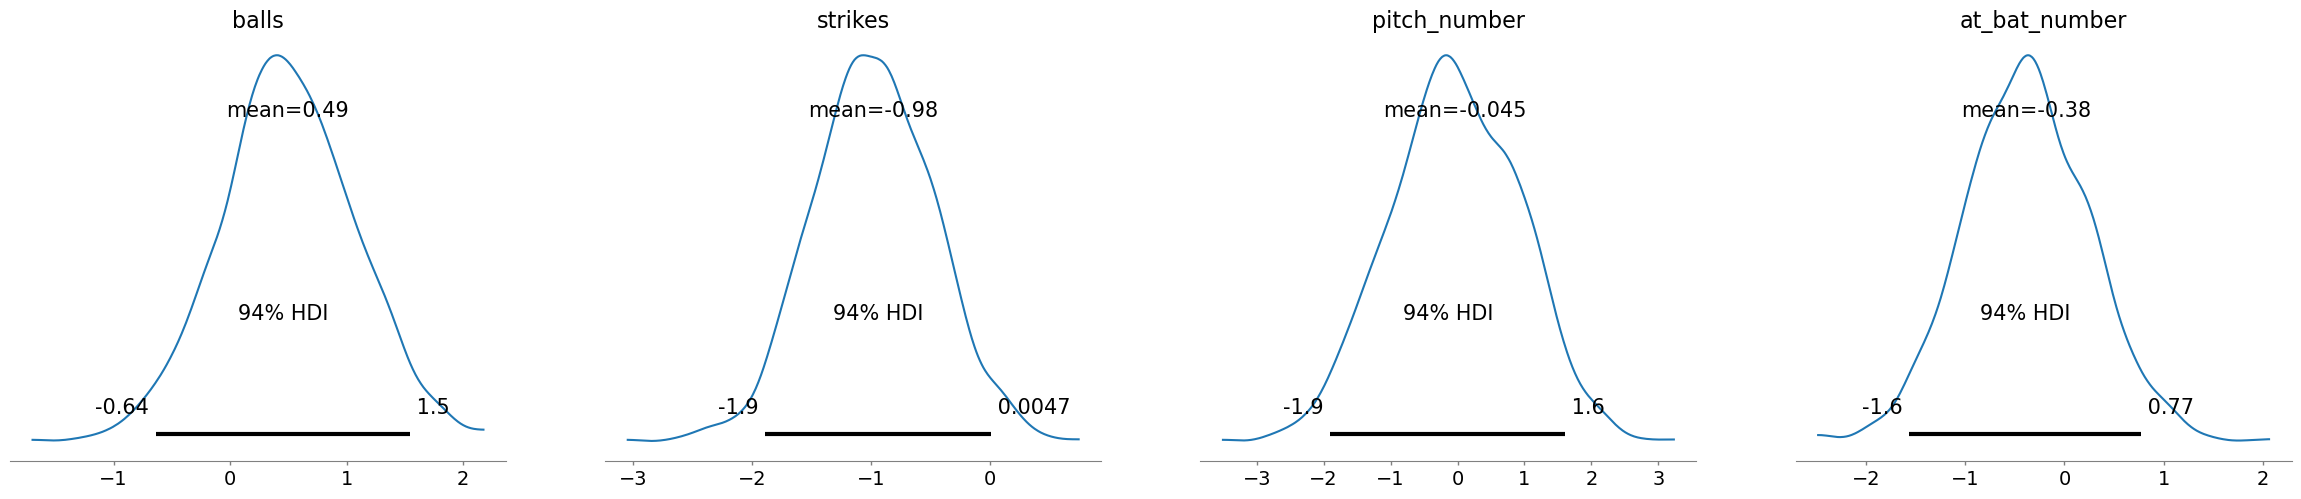

In [7]:
# Create first model looking at count
# balls, strikes, pitch type, zone
with pm.Model() as count_model:
    # Get priors for coefficients
    # How do we get priors? Answer this question later
    balls = pm.Normal("balls", mu=0, sigma=1)
    strikes = pm.Normal("strikes", mu=0, sigma=1)
    pitch_number = pm.Normal("pitch_number", mu=0, sigma=1)
    at_bat_number = pm.Normal("at_bat_number", mu=0, sigma=1)
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Initialize logistic model
    count_linear_pred = intercept + (X['balls'].values*balls) + (X['strikes'].values*strikes) + (X['pitch_number'].values*pitch_number) + (X['at_bat_number'].values*at_bat_number)
    count_log_sigmoid = pm.Deterministic("count_log_sigmoid", pm.math.sigmoid(count_linear_pred))

    # Likelihood
    count_y_obs = pm.Bernoulli("count_y_obs", p=count_log_sigmoid, observed=y_true)

    # Sampling
    count_trace = pm.sample(500)

    count_pred_samples = pm.sample_posterior_predictive(count_trace, var_names=["count_y_obs"])


# Plot posterior distributions
az.plot_posterior(count_trace, var_names=["balls", "strikes", "pitch_number", 'at_bat_number'])

In [9]:
# Get predictions from model
count_preds = count_pred_samples.posterior_predictive["count_y_obs"].mean(dim=["chain", "draw"]).values

# Make binary (cutoff at 0.5) and calculate accuracy 
count_binary_preds = (count_preds > 0.5).astype(int)
count_accuracy = np.mean(y_true == count_binary_preds)
print(f"Accuracy for count model: {count_accuracy*100}%")

Accuracy for count model: 84.5%


### Important Situation
**delta_home_win_exp, delta_run_exp, home_score, away_score, on_3b/2/1**